# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Третья лабораторная работа </center>
# <center> Фильтры </center>
В данной работе вы познакомитесь с понятием фильтра в цифровой обработке сигналов.

## Важные функции

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.fft
import librosa
import IPython.display as ipd
import librosa.display

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise')
%matplotlib inline

In [107]:
# from Lab2
def get_magnitude_from_spec(spec):
  return np.abs(spec)


def get_phi_from_spec(spec):
  return np.angle(spec)


# Функция отрисовки аудио сигнала.
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()

# Функция отрисовки спектра
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо,
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot

    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Magnitude spectrum")
        spec_A = get_magnitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()

    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return


----------------------------------------------
## Теория
Цифровой фильтр \([wiki](https://ru.wikipedia.org/wiki/Цифровой_фильтр)\) —  любой фильтр, обрабатывающий цифровой сигнал с целью выделения и/или подавления определённых частот этого сигнала.
Цифровые фильтры применяются практическе везде, где требуется обработка цифровых сигналов (при работе со звуком, картинками, видео и т.д.)

Основными характеристиками стационарных линейных дискретных фильтров являются:

* Импульсная характеристика
* Переходная характеристика
* Амплитудно-частотная характеристика
* Фазо-частотная характеристика

**Импульсной характеристикой фильтра** называется его реакция на единичный импульс при нулевых начальных условиях.

**Переходной характеристикой фильтра** называется его реакция на воздействие в форме единичной функции.

**Амплитудно-частотной характеристикой фильтра (АЧХ)** называется зависимость амплитуды установившихся колебаний выходного сигнала от частоты её входного гармонического сигнала. Другими словами, АЧХ показывает, как влияет фильтр на амплитуду разных частот входного сигнала.

**Фазо-частотной характеристикой фильтра (ФЧХ)** называется зависимость фазы установившихся колебаний выходного сигнала от частоты её входного гармонического сигнала. Аналогична АЧХ, только показывает влияние на фазу сигнала.

В данной работе мы будем рассматривать два линейных инвариантных к сдвигу фильтра: фильтр с конечной импульсной характеристикой (КИХ-фильтр) и фильтр с бесконечной импульсной характеристикой (БИХ-фильтр).
### КИХ-фильтры
Определение с [вики](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D1%81_%D0%BA%D0%BE%D0%BD%D0%B5%D1%87%D0%BD%D0%BE%D0%B9_%D0%B8%D0%BC%D0%BF%D1%83%D0%BB%D1%8C%D1%81%D0%BD%D0%BE%D0%B9_%D1%85%D0%B0%D1%80%D0%B0%D0%BA%D1%82%D0%B5%D1%80%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%BE%D0%B9) :
> Фильтр с конечной импульсной характеристикой (Нерекурсивный фильтр, КИХ-фильтр) или FIR-фильтр (FIR сокр. от finite impulse response — конечная импульсная характеристика) — один из видов линейных цифровых фильтров, характерной особенностью которого является ограниченность по времени его импульсной характеристики (с какого-то момента времени она становится точно равной нулю). Такой фильтр называют ещё нерекурсивным из-за отсутствия обратной связи. Знаменатель передаточной функции такого фильтра — константа.

<!-- ![resources/fir.png](resources/fir.png) -->


### БИХ-фильтры
Определение с [вики](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D1%81_%D0%B1%D0%B5%D1%81%D0%BA%D0%BE%D0%BD%D0%B5%D1%87%D0%BD%D0%BE%D0%B9_%D0%B8%D0%BC%D0%BF%D1%83%D0%BB%D1%8C%D1%81%D0%BD%D0%BE%D0%B9_%D1%85%D0%B0%D1%80%D0%B0%D0%BA%D1%82%D0%B5%D1%80%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%BE%D0%B9) :
> Фильтр с бесконечной импульсной характеристикой (Рекурсивный фильтр, БИХ-фильтр) или IIR-фильтр (IIR сокр. от infinite impulse response — бесконечная импульсная характеристика) — линейный электронный фильтр, использующий один или более своих выходов в качестве входа, то есть образующий обратную связь. Основным свойством таких фильтров является то, что их импульсная переходная характеристика имеет бесконечную длину во временной области, а передаточная функция имеет дробно-рациональный вид. Такие фильтры могут быть как аналоговыми, так и цифровыми.

<!-- ![resources/iir.png](resources/iir.png) -->

----------------------------

# Задание 1 (2 балла)
Реализуйте КИХ-фильтр и БИХ-фильтр

In [34]:
# Определяем фильтры
def FIR_filter(x, alpha_prev=0.5, alpha_curr=0.5):
  y = np.zeros_like(x)
  y[0] = alpha_curr * x[0]
  for i in range(1, len(x)):
    y[i] = alpha_prev * x[i - 1] + alpha_curr * x[i]
  return np.array(y)

def IIR_filter(x, alpha=0.5):
  # alpha - weight for reccurent connection
  y = np.zeros_like(x)
  y[0] = x[0]
  for i in range(1, len(x)):
    y[i] = alpha * y[i - 1] + x[i]
  return y

In [36]:
def test_filters():
    x = np.ones(10)
    y = FIR_filter(x)
    assert y[0] == 0.5 and (y[1:] == 1).all(), \
        RuntimeError(f"bad FIR. x={x}. y={y}")
    y = FIR_filter(x, alpha_prev=0.1, alpha_curr=0.9)
    assert y[0] == 0.9 and (y[1:] == 1).all(), \
        RuntimeError(f"bad FIR(alphas 0.1 and 0.9). x={x}. y={y}")
    y = IIR_filter(x)
    assert y[0]==1 and (y[3:].round() == 2).all() and (y<2).all(), \
        RuntimeError(f"Bad IIR. x={x}. y={y}")
    y = IIR_filter(x, 0.2)
    assert y[0]==1 and (y[3:].round(2) ==1.25).all() and (y<1.25).all(), \
        RuntimeError(f"Bad IIR(alpha={0.2}. x={x}. y={y}")
    print("All Ok!")

test_filters()

All Ok!


# Импульсная и переходная характеристики
# Задание 2 (1 балл)
<!-- Определите единичный импульс длиной 20 отсчетов (переменная impulse). <br>
Получите импульсную характеристику фильтров. -->

## Определите единичный импульс длиной 20 отсчетов (переменная impulse).

In [37]:
impulse = np.zeros(20)
impulse[0] = 1
print(impulse)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Получите импульсную характеристику фильтров (переменные FIR_filter и IIR_filter)

In [38]:
print("Импульсная характеристика фильтров с aplha=0.5:")
fir_impulse_response = FIR_filter(impulse)
iir_impulse_response = IIR_filter(impulse)
print(fir_impulse_response)
print(iir_impulse_response)

Импульсная характеристика фильтров с aplha=0.5:
[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[1.00000000e+00 5.00000000e-01 2.50000000e-01 1.25000000e-01
 6.25000000e-02 3.12500000e-02 1.56250000e-02 7.81250000e-03
 3.90625000e-03 1.95312500e-03 9.76562500e-04 4.88281250e-04
 2.44140625e-04 1.22070312e-04 6.10351562e-05 3.05175781e-05
 1.52587891e-05 7.62939453e-06 3.81469727e-06 1.90734863e-06]


Построим графики:

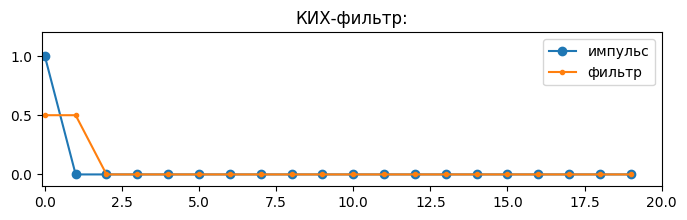

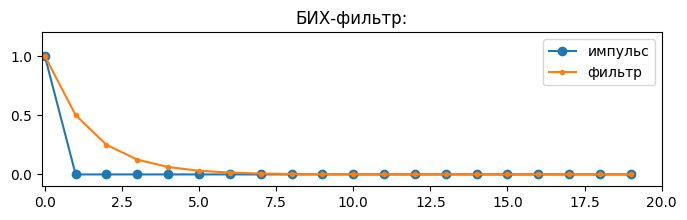

In [39]:
plt.figure(figsize=(8,2))
plt.title("КИХ-фильтр:")
plt.plot(impulse, 'o-')
plt.plot(fir_impulse_response, '.-')
plt.legend(['импульс', 'фильтр'])
plt.axis([-0.1, len(impulse), -0.1, 1.2])
plt.show()

plt.figure(figsize=(8,2))
plt.title("БИХ-фильтр:")
plt.plot(impulse, 'o-')
plt.plot(iir_impulse_response, '.-')
plt.legend(['импульс', 'фильтр'])
plt.axis([-0.1, len(impulse), -0.1, 1.2])
plt.show()

In [40]:
assert impulse.shape[0] == 20, "Bad impulse shape"
assert (fir_impulse_response[0:2] == 0.5).all() and \
        (fir_impulse_response[2:] == 0).all(), "Bad FIR."
assert iir_impulse_response.sum().round() == 2 and \
        iir_impulse_response.sum() < 2 and \
        (iir_impulse_response != 0).all(), "Bad IIR."
assert iir_impulse_response[1:].sum().round() == 1 and \
        iir_impulse_response[1:].sum()<1 and \
        iir_impulse_response[2:].sum() < 0.5, "Bad IIR."
print("All ok!")

All ok!


# Задание 3 (1 балл)
<!-- Определите единичный скачок длиной 20 отсчетов (переменная step). <br>
Получите переходную характеристику фильтров. -->

## Определите единичный скачок длиной 20 отсчетов
(переменная step).

In [73]:
step = np.full(20, 1.0)
print(step)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Получите импульсную характеристику фильтров

In [74]:
print("Переходная характеристика фильтров с alpha=0.5:")
fir_step_response = FIR_filter(step)
iir_step_response = IIR_filter(step)
print(fir_step_response)
print(iir_step_response)

Переходная характеристика фильтров с alpha=0.5:
[0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1. ]
[1.         1.5        1.75       1.875      1.9375     1.96875
 1.984375   1.9921875  1.99609375 1.99804688 1.99902344 1.99951172
 1.99975586 1.99987793 1.99993896 1.99996948 1.99998474 1.99999237
 1.99999619 1.99999809]


Построим графики:

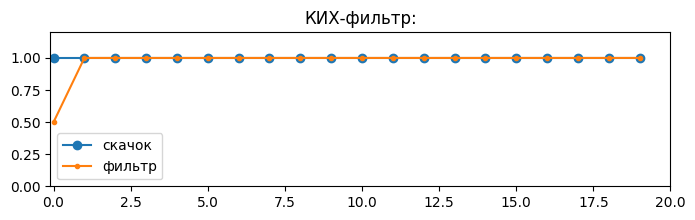

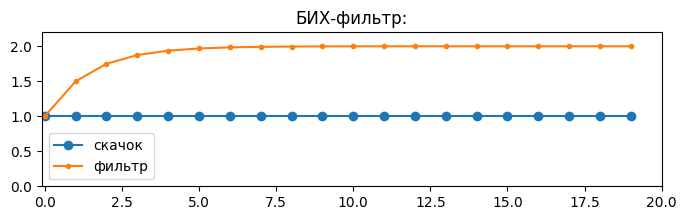

In [75]:
plt.figure(figsize=(8,2))
plt.title("КИХ-фильтр:")
plt.plot(step, 'o-')
plt.plot(fir_step_response, '.-')
plt.axis([-0.1, len(step), 0, 1.2])
plt.legend(['скачок', 'фильтр'])

plt.show()

plt.figure(figsize=(8,2))
plt.title("БИХ-фильтр:")
plt.plot(step, 'o-')
plt.plot(iir_step_response, '.-')
plt.axis([-0.1, len(step), 0, 2.2])
plt.legend(['скачок', 'фильтр'])
plt.show()

In [76]:
assert step.shape[0] == 20, "Bad step shape"
assert fir_step_response[0] == 0.5 and \
        (fir_step_response[1:] == 1).all(), "Bad FIR."
assert iir_step_response[0] == 1 and iir_step_response[1] == 1.5 and iir_step_response[2] == 1.75 and \
        iir_step_response.mean().round() == 2 and (iir_step_response < 2).all(), "Bad IIR."
print("All ok!")

All ok!


# Амплитудно-частотная и фазо-частотная характеристики
# Задание 4 (1 балл)
Получите амплитудно-частотную характеристику фильтров для единичного импульса (переменная impulse).

In [112]:
print("Амплитудно-частотная характеристика фильтров с alpha=0.5")

# Получить амплитудно-частотную характеристику
fir_imp = FIR_filter(impulse)
iir_imp = IIR_filter(impulse)

fir_frequency_response = get_magnitude_from_spec(np.fft.fft(fir_imp))[:len(impulse)//2]
iir_frequency_response = get_magnitude_from_spec(np.fft.fft(iir_imp))[:len(impulse)//2]

freqs = np.fft.fftfreq(len(impulse), d = 1)

Амплитудно-частотная характеристика фильтров с alpha=0.5


Построим графики:

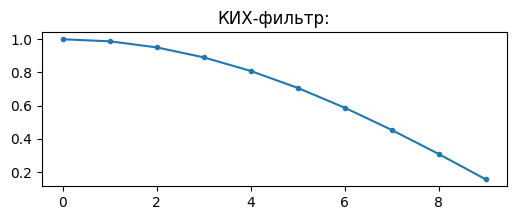

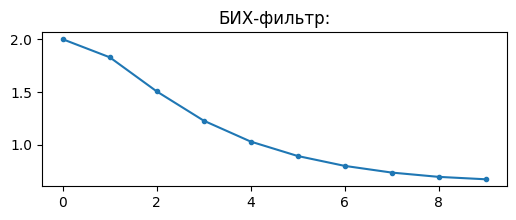

In [113]:
plt.figure(figsize=(6,2))
plt.title("КИХ-фильтр:")
plt.plot(fir_frequency_response, '.-')
plt.show()

plt.figure(figsize=(6,2))
plt.title("БИХ-фильтр:")
plt.plot(iir_frequency_response, '.-')
plt.show()

In [114]:
assert fir_frequency_response.shape[0] == iir_frequency_response.shape[0] == 10, \
    f"Bad FR shape. Must be N//2."
_ideal_fir_fr = np.array([1. , 0.98768834, 0.95105652, 0.89100652, 0.80901699,
       0.70710678, 0.58778525, 0.4539905 , 0.30901699, 0.15643447])
assert np.allclose(fir_frequency_response, _ideal_fir_fr), \
    f"Bad fir FR. diff is {np.abs(fir_frequency_response - _ideal_fir_fr).sum()}"
_ideal_iir_fr = np.array([1.99999809, 1.82896351, 1.50587408, 1.22885364, 1.03088138,
       0.89442634, 0.80089238, 0.73765316, 0.69689865, 0.67403739])
assert np.allclose(iir_frequency_response, _ideal_iir_fr), \
    f"Bad iir FR. diff is {np.abs(iir_frequency_response - _ideal_iir_fr).sum()}"

print("All ok!")

All ok!


# Задание 5 (1 балл)
Получите фазово-частотную характеристику фильтров для единичного импульса (переменная impulse).

In [115]:
print("Фазово-частотная характеристика")

fir_imp = FIR_filter(impulse)
iir_imp = IIR_filter(impulse)

fir_phase_response = get_phi_from_spec(np.fft.fft(fir_imp))[:len(impulse)//2]
iir_phase_response = get_phi_from_spec(np.fft.fft(iir_imp))[:len(impulse)//2]

freqs = np.fft.fftfreq(len(impulse), d = 1)

Фазово-частотная характеристика


Построим графики:

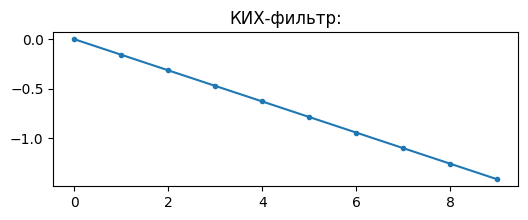

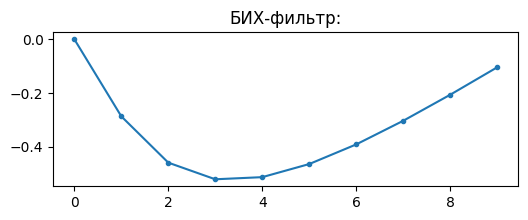

In [116]:
plt.figure(figsize=(6,2))
plt.title("КИХ-фильтр:")
plt.plot(fir_phase_response, '.-')
plt.show()

plt.figure(figsize=(6,2))
plt.title("БИХ-фильтр:")
plt.plot(iir_phase_response, '.-')
plt.show()

In [117]:
assert fir_phase_response.shape[0] == iir_phase_response.shape[0] == 10, \
    f"Bad PR shape. Must be N//2."
_ideal_fir_pr = np.array([-0.        , -0.15707963, -0.31415927, -0.4712389 , -0.62831853,
       -0.78539816, -0.9424778 , -1.09955743, -1.25663706, -1.41371669])
assert np.allclose(fir_phase_response, _ideal_fir_pr), \
    f"Bad fir PR. diff is {np.abs(fir_phase_response - _ideal_fir_pr).sum()}"
_ideal_iir_pr = np.array([-0.        , -0.28649379, -0.45845783, -0.52023287, -0.51233491,
       -0.46364761, -0.39071251, -0.30300249, -0.20627323, -0.10433379])
assert np.allclose(iir_phase_response, _ideal_iir_pr), \
    f"Bad iir PR. diff is {np.abs(iir_phase_response - _ideal_iir_pr).sum()}"

print("All ok!")

All ok!
